loss 0.015, train acc 0.996, test acc 0.890
518.4 examples/sec on cuda:0


TypeError: can only concatenate str (not "float") to str

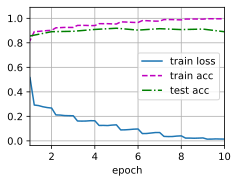

In [1]:
import torch
from torch import nn
import sys
import d2l
from d2l.torch import load_data_fashion_mnist
from d2l.torch import train_ch6
from d2l.torch import try_gpu
from torch.nn import functional as F
import time

##构建残差块
class Residual(nn.Module):
    def __init__(self,in_channes,out_channes,use_1x1_conv=False,stride = 1):
        super().__init__()
        if use_1x1_conv:
            self.res = nn.Sequential(
                nn.Conv2d(in_channes,out_channes,kernel_size=1,stride=stride)
            )
        else:
            self.res = nn.Sequential()
        self.model =nn.Sequential(
            nn.Conv2d(in_channes,out_channes,kernel_size=3,padding=1,stride=stride),
            nn.BatchNorm2d(out_channes),
            nn.ReLU(),
            nn.Conv2d(out_channes,out_channes,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channes)
        )
 
    def forward(self,x):
        ret = self.model(x)
        ret = ret+self.res(x)
        return F.relu(ret)

def resnet_block(num_residuals, input_channels, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1_conv=True, stride=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

##构建残差网络
in_channels = 1
b1 = nn.Sequential(
    nn.Conv2d(in_channels,64,kernel_size=7,stride=2,padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)
b2 = nn.Sequential(*resnet_block(2,64,64, first_block=True))
b3 = nn.Sequential(*resnet_block(2,64,128))
b4 = nn.Sequential(*resnet_block(2,128,256))
b5 = nn.Sequential(*resnet_block(2,256,512))

resnet = nn.Sequential(b1,b2,b3,b4,b5,
                  nn.AdaptiveAvgPool2d((1,1)),
                  nn.Flatten(),nn.Linear(512,10)
                  )

##测试网络是否有效
test = torch.rand((1,1,224,224))
print("test net")
for layer in resnet:
    test = layer(test)
    print(layer.__class__.__name__,"shape:",test.shape)

##设置参数
lr,num_epochs,batch_size = 0.05,10, 128
train_iter,test_iter =load_data_fashion_mnist(batch_size,resize=224)
train_ch6(resnet,train_iter,test_iter,num_epochs,lr,try_gpu())
torch.save(resnet.state_dict(), 'resnet_18.params')